In [1]:
import pandas as pd
import nltk
import string
import re
import matplotlib.pyplot as plt
import demoji



from time import sleep
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.keys import Keys
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud

In [2]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('snowball_data')
# demoji.download_codes()

In [3]:

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')


In [4]:

def search(query: str):
    options = Options()
    options.add_argument("--headless") 
    options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36')
    driver = webdriver.Chrome(options=options)

    # Navigate to Google
    driver.get("https://www.google.com")

    # Wait for the search box to be visible
    wait = WebDriverWait(driver, 10)
    search_box = wait.until(EC.visibility_of_element_located((By.NAME, "q")))

    # Enter the query and submit
    search_box.send_keys(f"{query} review site: youtube.com")
    search_box.send_keys(Keys.RETURN)

    # Wait for the page to load
    driver.implicitly_wait(5)

    # Get the top 5 links
    links = driver.find_elements(By.XPATH, "//div[@class='ct3b9e']//a")
    urls = [link.get_attribute("href") for link in links[:10]]

    driver.quit()
    
    return urls


In [5]:
query = "samsung s23 ultra"
urls = search(query)

In [6]:
def getComments(url):
    
    # Set up Chrome driver options
    chrome_options = Options()
    # chrome_options.add_argument("--headless") 
    chrome_options.add_argument("--disable-extensions")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    # Initialize ChromeDriver with an implicit wait of 10 seconds
    driver = webdriver.Chrome(options=chrome_options)
    driver.implicitly_wait(20)

    # Open the video page
    driver.get(url)
    sleep(15)

    # Wait for the comment section to load
    wait = WebDriverWait(driver, 20)
    wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="continuations"]')))

    # Scroll down to the bottom of the page to load all comments
    driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
    sleep(7)
    comment_list = []

    # Find the comment div element and extract the comments
    try:
        comment_div = driver.find_element(By.XPATH, '//*[@id="contents"]')
        comments = comment_div.find_elements(By.XPATH, '//*[@id="content-text"]')
        for comment in comments:
            comment_list.append(comment.text.strip())
    except NoSuchElementException:
        print("Could not find comment section.")
    finally:
        driver.quit()
        return comment_list


In [10]:
comments = []
for url in tqdm(urls):
    sleep(10)
    com = getComments(url)
    comments.extend(com)
    
    

 40%|█████████████████████████████████▏                                                 | 4/10 [03:57<05:55, 59.32s/it]


WebDriverException: Message: unknown error: cannot determine loading status
from no such window
  (Session info: chrome=113.0.5672.93)
Stacktrace:
Backtrace:
	GetHandleVerifier [0x00CADCE3+50899]
	(No symbol) [0x00C3E111]
	(No symbol) [0x00B45450]
	(No symbol) [0x00B3879A]
	(No symbol) [0x00B37118]
	(No symbol) [0x00B3778A]
	(No symbol) [0x00B40B74]
	(No symbol) [0x00B4AB28]
	(No symbol) [0x00B4D4D6]
	(No symbol) [0x00B37AE3]
	(No symbol) [0x00B4A835]
	(No symbol) [0x00B9E219]
	(No symbol) [0x00B8B6F6]
	(No symbol) [0x00B67708]
	(No symbol) [0x00B6886D]
	GetHandleVerifier [0x00F13EAE+2566302]
	GetHandleVerifier [0x00F492B1+2784417]
	GetHandleVerifier [0x00F4327C+2759788]
	GetHandleVerifier [0x00D45740+672048]
	(No symbol) [0x00C48872]
	(No symbol) [0x00C441C8]
	(No symbol) [0x00C442AB]
	(No symbol) [0x00C371B7]
	BaseThreadInitThunk [0x75CD00F9+25]
	RtlGetAppContainerNamedObjectPath [0x77187BBE+286]
	RtlGetAppContainerNamedObjectPath [0x77187B8E+238]


In [11]:
df = pd.DataFrame({'comments':comments})

In [12]:
# df.to_csv('comments.csv', index = False)

In [13]:
# df = pd.read_csv('comments.csv')

In [14]:
def clean_text(text, device_name = query):
    # Convert text to lowercase
    text = text.lower()

    # Remove device name
    device_name = device_name.lower()
    device_name_terms = [term.strip() for term in device_name.split()]
    device_name_regex = '|'.join(device_name_terms)
    text = re.sub(device_name_regex, '', text)

    # Remove terms related to device
    remove_terms = ['phone', 'review', 'display', 'use', 'upgrade', 'screen', 'battery', 'year', 'video', 'watch'] + device_name_terms
    remove_terms_regex = '|'.join(remove_terms)
    text = re.sub(remove_terms_regex, '', text)

    # Remove punctuation marks
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers and special characters
    text = re.sub('[^a-zA-Z ]', '', text)

    # Remove URLs and mentions
    text = re.sub(r'http\S+', '', text)
    text = re.sub('@[^\s]+', '', text)

    # Remove emojis
    text = remove_emojis(text)

    # Tokenize the text into words
    words = word_tokenize(text)

    # Remove stop words
    words = [word for word in words if word not in stop_words]

    # Stem the words
    words = [stemmer.stem(word) for word in words]

    # Join the words back into a string
    text = ' '.join(words)

    return text

def remove_emojis(text):
    return demoji.replace(text, '')


In [15]:
df['cleaned_comments'] = df.comments.apply(clean_text)
df['cleaned_comments'] = df.cleaned_comments.apply(remove_emojis)

In [16]:

# Create an instance of the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Apply the sentiment analyzer to each comment
df['sentiment_scores'] = df['cleaned_comments'].apply(lambda x: sid.polarity_scores(x))

# Extract the compound score from the sentiment scores
df['compound_score'] = df['sentiment_scores'].apply(lambda x: x['compound'])

# Categorize the comments as positive, negative, or neutral based on the compound score
df['sentiment_category'] = pd.cut(df['compound_score'], bins=3, labels=['negative', 'neutral', 'positive'])


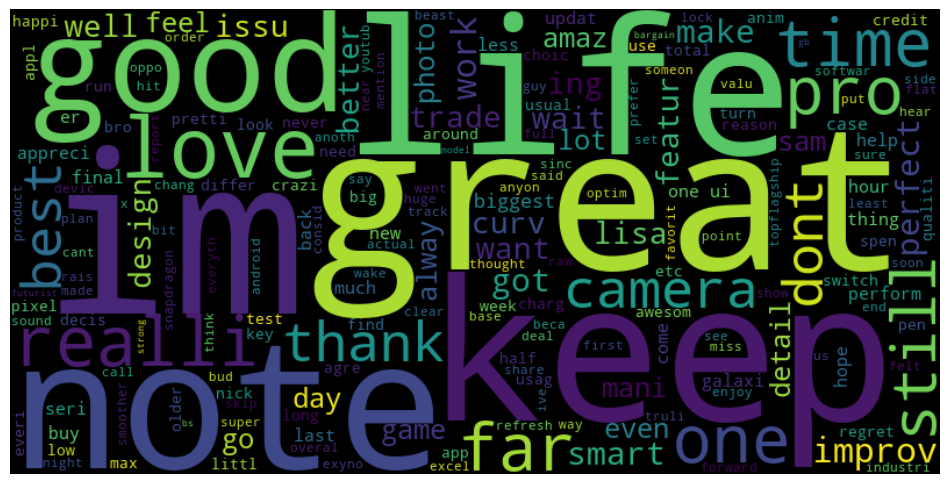

In [17]:

# Join the words in the cleaned comments to a single string
text = ' '.join(df['cleaned_comments'])

# Create a word cloud object and generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

# Plot the word cloud
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [18]:
df

,comments,cleaned_comments,sentiment_scores,compound_score,sentiment_category
0,I've had my Note 10 for well over 3 years now ...,ive note well im still amaz bargain great futu...,"{'neg': 0.0, 'neu': 0.511, 'pos': 0.489, 'comp...",0.9360,positive
1,The review that we all are waiting for. Thanks...,wait thank bs thought alway lisa,"{'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'comp...",0.3612,neutral
2,The upgrade of the S23 series is like when Sam...,seri like went note fix everyth wrong first on...,"{'neg': 0.177, 'neu': 0.41, 'pos': 0.413, 'com...",0.7845,positive
3,This channel IMHO is the gold standard of cell...,channel imho gold standard cell,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,negative
4,Those cases look pretty good. I'm going to che...,case look pretti good im go check silicon case...,"{'neg': 0.0, 'neu': 0.566, 'pos': 0.434, 'comp...",0.8020,positive
...,...,...,...,...,...
75,Did you get scratches & paint fading issues on...,get scratch paint fade issu side aluminium fra...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,negative
76,I'm waiting for the battery drain test of the ...,im wait drain test honor magic pro oppo find x...,"{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'comp...",0.4939,neutral
77,Another great video thanks bro.,anoth great thank bro,"{'neg': 0.0, 'neu': 0.233, 'pos': 0.767, 'comp...",0.7650,positive
78,Very good review,good,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.4404,neutral
